In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.model_selection import cross_val_score
from sklearn.impute import KNNImputer
from sklearn.pipeline import Pipeline

try:
    from sklearnex import patch_sklearn
    patch_sklearn()
except ModuleNotFoundError:
    pass

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


In [4]:
try:
    X = pd.read_feather("./data/train_data.feather")
    y = pd.read_feather("./data/train_label.feather")

except FileNotFoundError:
    X = pd.read_csv("./data/train_data.csv", parse_dates=["date_recorded"], dtype_backend="pyarrow")
    y = pd.read_csv("./data/train_label.csv", dtype_backend="pyarrow")
    # waterpoint name and subvillage are redundant and have all unique values
    X = X.drop(["wpt_name", "subvillage"], axis="columns")

    for feature in X.select_dtypes("string").columns:
        dummies = pd.get_dummies(X[feature], prefix=feature, prefix_sep=" ")
        X.drop(feature, axis="columns", inplace=True)
        X = pd.concat([X, dummies], axis='columns')

    y["status_group"].replace(['functional', 'non functional', 'functional needs repair'],[0,1,2],inplace=True)
    y.to_feather("./data/train_label.feather")
    X.to_feather("./data/train_data.feather")
    X.columns.to_series().to_csv("./data/columns.csv")

In [5]:
df = pd.concat([X,y], axis="columns")
df = df.dropna(axis=0)
X, y = df.iloc[:,:-1], df.iloc[:,-1]
dtree = DecisionTreeClassifier(max_depth=3)
cross_val_score(dtree,X.select_dtypes(exclude="datetime"), y, n_jobs=-1)

array([0.69156423, 0.69191066, 0.69528904, 0.69256757, 0.70167042])

In [ ]:
if False:
    # impute takes forever
    dtree = Pipeline(
        [
            ('Imputer', KNNImputer(n_neighbors=3, weights='distance')),
            ('Classifier', DecisionTreeClassifier(max_depth=3)),
        ]
    )
    #
    cross_val_score(dtree,X.select_dtypes(exclude="datetime"),y, n_jobs=-1)

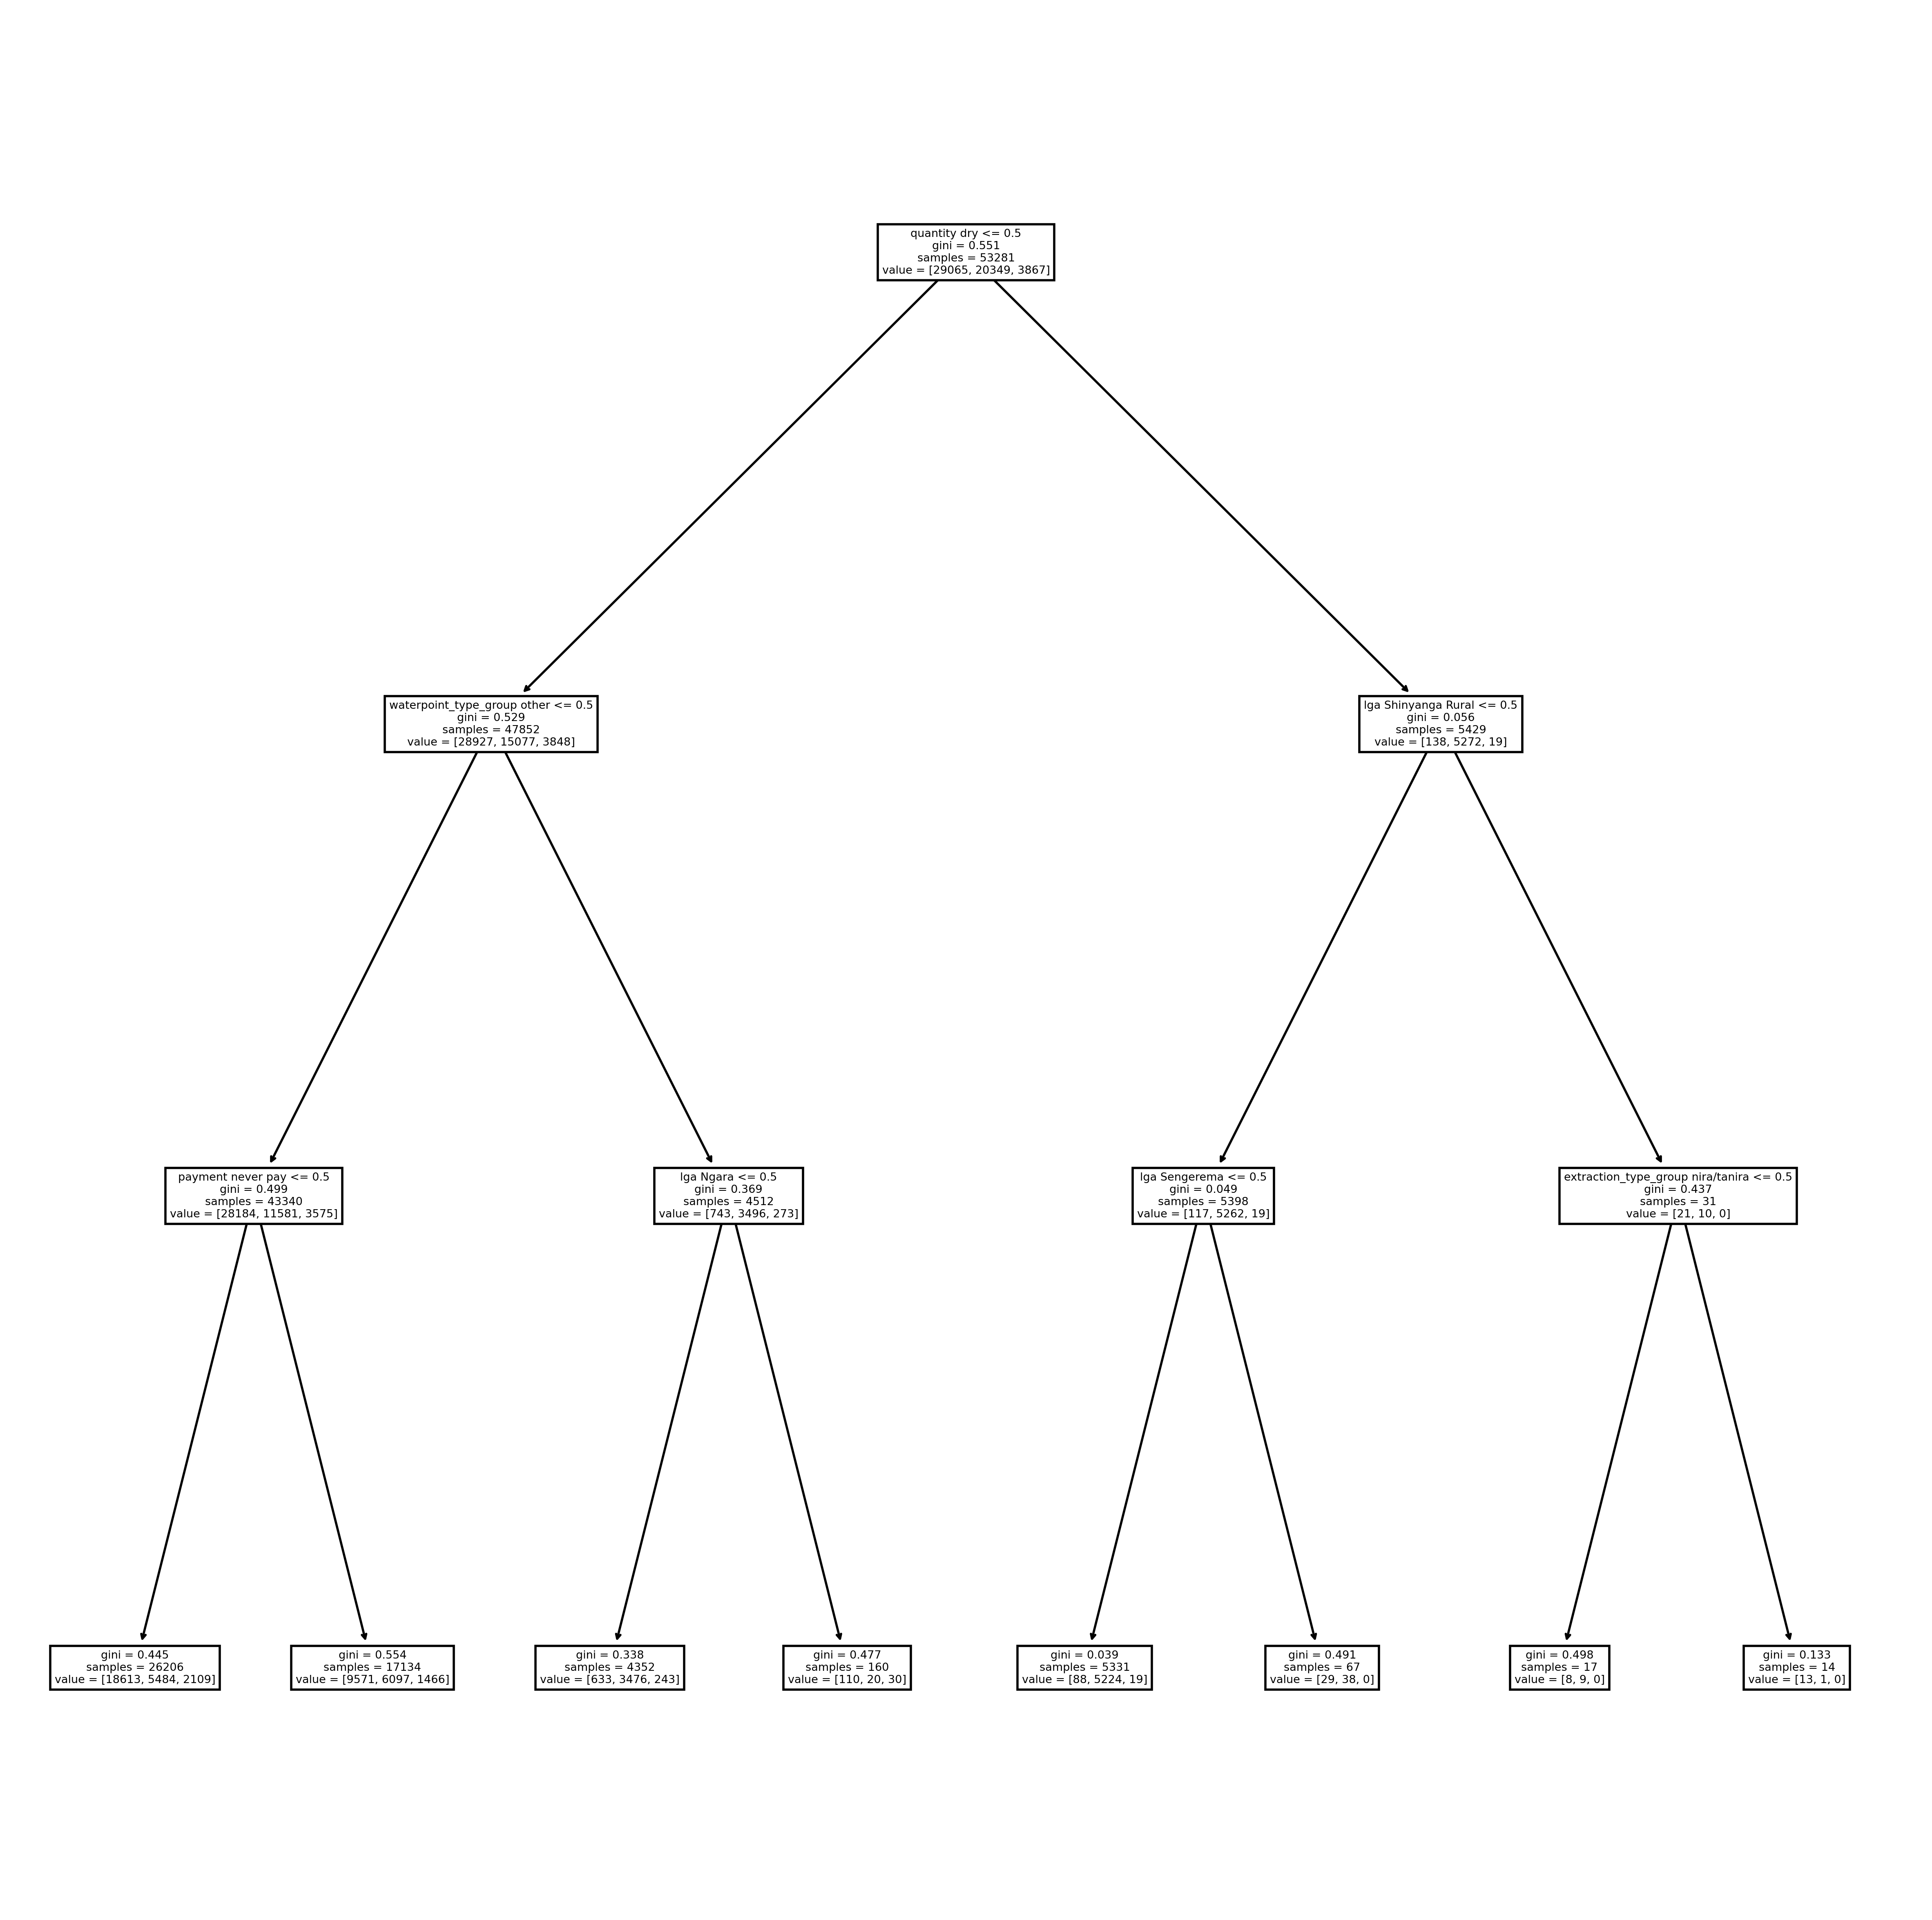

In [7]:
dtree.fit(X.select_dtypes(exclude="datetime"),y)
plt.figure(dpi=400, figsize=(15,15))
tplot = plot_tree(dtree, feature_names=list(X.select_dtypes(exclude="datetime").columns))